In [1]:
import pandas as pd
import numpy as np
import keras
import scipy
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
from sklearn.model_selection import GroupKFold
from sklearn import linear_model
from lineartree import RandomForestRegressor
from sklearn import metrics
from scipy.signal import savgol_filter
from keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [2]:
from numpy.random import seed
seed(1)
from tensorflow.keras.utils import set_random_seed
set_random_seed(2)

In [3]:
def rae(actual, predicted):
    actual = np.asarray(actual).reshape(-1,1)
    predicted = np.asarray(predicted).reshape(-1,1)
    numerator = np.sum(np.abs(predicted - actual))
    denominator = np.sum(np.abs(np.mean(actual) - actual))
    return numerator / denominator

In [4]:
def peak_eV_nm(peak_eV):
    peak_eV = np.asarray(peak_eV).reshape(-1,1)
    return 1239.84193/peak_eV

In [5]:
def FWHM_eV_nm(peak_eV,fwhm_eV):
    peak_eV = np.asarray(peak_eV).reshape(-1,1)
    fwhm_eV = np.asarray(fwhm_eV).reshape(-1,1)
    return  2*(1239.84193/(peak_eV-fwhm_eV/2) - 1239.84193/(peak_eV))

In [6]:
def predict_dist(X, model, num_samples):
    preds = [model(X, training=True) for _ in range(num_samples)]
    return np.hstack(preds)

In [7]:
def predict_point(X, model, num_samples):
    pred_dist = predict_dist(X, model, num_samples)
    return pred_dist.mean(axis=1)

In [8]:
def predict_stdev(X, model, num_samples):
    pred_dist = predict_dist(X, model, num_samples)
    return pred_dist.std(axis=1)

In [9]:
#Define models

initializer = keras.initializers.HeNormal(seed=1)
opt = keras.optimizers.Adam(learning_rate=0.001)

model_peak = keras.models.Sequential()
model_peak.add(Dense(5, input_shape=(5,), kernel_initializer=initializer, activation='relu'))
model_peak.add(Dense(50,  activation='relu'))
model_peak.add(keras.layers.Dropout(0.1))
model_peak.add(Dense(50,  activation='relu'))
model_peak.add(keras.layers.Dropout(0.1))
model_peak.add(Dense(1, kernel_initializer=initializer))
# Compile model
model_peak.compile(loss='mean_squared_error', optimizer= opt)

model_fwhm = keras.models.Sequential()
model_fwhm.add(Dense(5, input_shape=(5,), kernel_initializer=initializer, activation='relu'))
model_fwhm.add(Dense(50,  activation='relu'))
model_fwhm.add(keras.layers.Dropout(0.1))
model_fwhm.add(Dense(50,  activation='relu'))
model_fwhm.add(keras.layers.Dropout(0.1))
model_fwhm.add(Dense(1, kernel_initializer=initializer))
# Compile model
model_fwhm.compile(loss='mean_squared_error', optimizer= opt)

model_cascade = keras.models.Sequential()
model_cascade.add(Dense(6, input_shape=(6,), kernel_initializer=initializer, activation='relu'))
model_cascade.add(Dense(50,  activation='relu'))
model_cascade.add(keras.layers.Dropout(0.1))
model_cascade.add(Dense(50,  activation='relu'))
model_cascade.add(keras.layers.Dropout(0.1))
model_cascade.add(Dense(1, kernel_initializer=initializer))
# Compile model
model_cascade.compile(loss='mean_squared_error', optimizer= opt)

In [10]:
#Train model on entire dataset (Absorbance)
# load dataset into Pandas DataFrame (cleaned PL data)
df = pd.read_csv('CdSe PL Train Val.csv')

#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
X2 = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]
y = df['Peak_eV']
z = df['FWHM_eV']

matrix = np.zeros([1,8])
matrix_fwhm = np.zeros([1,8])
matrix_cascade = np.zeros([1,8])

#Separate out training and test sets (in this case they are the same)
X_train = X
X2_train = X2
y_train = y
z_train = z
X_test = X
X2_test = X2
y_test = y
z_test = z
j=0

#Initialize with fixed weights
model_peak.load_weights('initialize_weights3.h5')
model_fwhm.load_weights('initialize_weights3.h5')
model_cascade.load_weights('initialize_weights4.h5')

#Train models
#prediction for Peak
model_peak.fit(X_train, y_train, epochs=300, validation_data=(X_test, y_test),verbose = 1, use_multiprocessing=False, workers = 100)
y_pred = model_peak.predict(X_test)
#prediction for FWHM (direct)
model_fwhm.fit(X_train, z_train, epochs=300, validation_data=(X_test, z_test),verbose = 1, use_multiprocessing=False, workers = 100)
y_pred_fwhm = model_fwhm.predict(X_test)
#prediction for FWHM (cascade)
model_cascade.fit(X2_train, z_train, epochs=300, validation_data=(X2_test, z_test),verbose = 1, use_multiprocessing=False, workers = 100)
X_test.insert(5, "Peak_eV", model_peak.predict(X_test), True)
y_pred_cascade = model_cascade.predict(X_test)

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorption Peak/FWHM Training Accuracy (no dropout at inference)' + '\033[0m')
print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

# serialize weights to HDF5
#model_peak.save_weights("Emi_peak_1000.h5")
#model_fwhm.save_weights("Emi_fwhm_1000.h5")
#model_cascade.save_weights("Emi_cascade_1000.h5")

Epoch 1/300
159/159 [==============================] - 1s 3ms/step - loss: 0.0219 - val_loss: 0.0067
Epoch 2/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 0.0041
Epoch 3/300
159/159 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 0.0031
Epoch 4/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 0.0030
Epoch 5/300
159/159 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 6/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0023
Epoch 7/300
159/159 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 8/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0021
Epoch 9/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0021
Epoch 10/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0027 - val_lo

159/159 [==============================] - 0s 1ms/step - loss: 6.3388e-04 - val_loss: 3.5902e-04
Epoch 152/300
159/159 [==============================] - 0s 1ms/step - loss: 6.7227e-04 - val_loss: 4.1045e-04
Epoch 153/300
159/159 [==============================] - 0s 1ms/step - loss: 6.5754e-04 - val_loss: 4.0917e-04
Epoch 154/300
159/159 [==============================] - 0s 1ms/step - loss: 6.5937e-04 - val_loss: 4.4222e-04
Epoch 155/300
159/159 [==============================] - 0s 1ms/step - loss: 6.6034e-04 - val_loss: 3.4680e-04
Epoch 156/300
159/159 [==============================] - 0s 1ms/step - loss: 6.8047e-04 - val_loss: 3.7260e-04
Epoch 157/300
159/159 [==============================] - 0s 1ms/step - loss: 6.4852e-04 - val_loss: 3.7719e-04
Epoch 158/300
159/159 [==============================] - 0s 2ms/step - loss: 6.2464e-04 - val_loss: 3.8226e-04
Epoch 159/300
159/159 [==============================] - 0s 1ms/step - loss: 6.4442e-04 - val_loss: 4.1660e-04
Epoch 160/300
1

Epoch 225/300
159/159 [==============================] - 0s 2ms/step - loss: 5.9210e-04 - val_loss: 3.5762e-04
Epoch 226/300
159/159 [==============================] - 0s 1ms/step - loss: 6.0971e-04 - val_loss: 3.6400e-04
Epoch 227/300
159/159 [==============================] - 0s 1ms/step - loss: 6.2006e-04 - val_loss: 3.2471e-04
Epoch 228/300
159/159 [==============================] - 0s 1ms/step - loss: 6.3293e-04 - val_loss: 2.9678e-04
Epoch 229/300
159/159 [==============================] - 0s 1ms/step - loss: 6.0405e-04 - val_loss: 3.0212e-04
Epoch 230/300
159/159 [==============================] - 0s 1ms/step - loss: 6.1091e-04 - val_loss: 2.9972e-04
Epoch 231/300
159/159 [==============================] - 0s 1ms/step - loss: 6.0889e-04 - val_loss: 4.7589e-04
Epoch 232/300
159/159 [==============================] - 0s 1ms/step - loss: 6.0364e-04 - val_loss: 2.8680e-04
Epoch 233/300
159/159 [==============================] - 0s 2ms/step - loss: 6.0050e-04 - val_loss: 3.4250e-04
E

Epoch 299/300
159/159 [==============================] - 0s 1ms/step - loss: 6.0318e-04 - val_loss: 2.8944e-04
Epoch 300/300
159/159 [==============================] - 0s 633us/step
Epoch 1/300
159/159 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0028
Epoch 2/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 3/300
159/159 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 4/300
159/159 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 5/300
159/159 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 6/300
159/159 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 7/300
159/159 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 8/300
159/159 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 9/30

159/159 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 9.5207e-04
Epoch 157/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 9.1880e-04
Epoch 158/300
159/159 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 9.5515e-04
Epoch 159/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 9.8272e-04
Epoch 160/300
159/159 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 9.0277e-04
Epoch 161/300
159/159 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 9.2564e-04
Epoch 162/300
159/159 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 9.3268e-04
Epoch 163/300
159/159 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 164/300
159/159 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 9.2123e-04
Epoch 165/300
159/159 [==============================] 

159/159 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 8/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 9/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 10/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 11/300
159/159 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 12/300
159/159 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 13/300
159/159 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 14/300
159/159 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 15/300
159/159 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 16/300
159/159 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.

159/159 [==============================] - 0s 1ms/step - loss: 7.6296e-04 - val_loss: 6.7310e-04
Epoch 160/300
159/159 [==============================] - 0s 2ms/step - loss: 7.0034e-04 - val_loss: 5.4923e-04
Epoch 161/300
159/159 [==============================] - 0s 1ms/step - loss: 7.0778e-04 - val_loss: 5.4437e-04
Epoch 162/300
159/159 [==============================] - 0s 2ms/step - loss: 7.5092e-04 - val_loss: 5.6028e-04
Epoch 163/300
159/159 [==============================] - 0s 1ms/step - loss: 7.3511e-04 - val_loss: 5.5999e-04
Epoch 164/300
159/159 [==============================] - 0s 1ms/step - loss: 7.2898e-04 - val_loss: 5.7567e-04
Epoch 165/300
159/159 [==============================] - 0s 1ms/step - loss: 7.4438e-04 - val_loss: 5.5986e-04
Epoch 166/300
159/159 [==============================] - 0s 1ms/step - loss: 6.8559e-04 - val_loss: 5.0757e-04
Epoch 167/300
159/159 [==============================] - 0s 1ms/step - loss: 7.2690e-04 - val_loss: 6.0012e-04
Epoch 168/300
1

Epoch 233/300
159/159 [==============================] - 0s 1ms/step - loss: 6.4937e-04 - val_loss: 5.4828e-04
Epoch 234/300
159/159 [==============================] - 0s 1ms/step - loss: 6.6342e-04 - val_loss: 5.0774e-04
Epoch 235/300
159/159 [==============================] - 0s 1ms/step - loss: 6.5453e-04 - val_loss: 4.7960e-04
Epoch 236/300
159/159 [==============================] - 0s 2ms/step - loss: 6.6223e-04 - val_loss: 5.1319e-04
Epoch 237/300
159/159 [==============================] - 0s 1ms/step - loss: 6.4794e-04 - val_loss: 5.3235e-04
Epoch 238/300
159/159 [==============================] - 0s 2ms/step - loss: 6.7350e-04 - val_loss: 4.9331e-04
Epoch 239/300
159/159 [==============================] - 0s 1ms/step - loss: 6.4989e-04 - val_loss: 5.3417e-04
Epoch 240/300
159/159 [==============================] - 0s 2ms/step - loss: 6.5442e-04 - val_loss: 4.9367e-04
Epoch 241/300
159/159 [==============================] - 0s 2ms/step - loss: 6.4902e-04 - val_loss: 5.0303e-04
E

In [11]:
#Predictions with dropout

# load dataset into Pandas DataFrame (cleaned PL data)
df = pd.read_csv('CdSe PL Train Val.csv')

#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
X2 = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]
y = df['Peak_eV']
z = df['FWHM_eV']

matrix = np.zeros([1,8])
matrix_fwhm = np.zeros([1,8])
matrix_cascade = np.zeros([1,8])

#Separate out training and test sets (in this case they are the same)
X_train = X
X2_train = X2
y_train = y
z_train = z
X_test = X
y_test = y
z_test = z

X_test_t = K.constant(X_test)

#prediction for Peak
y_pred =  predict_point(X_test_t, model_peak, 1000)
#prediction for FWHM (direct)
y_pred_fwhm = predict_point(X_test_t, model_fwhm, 1000)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", y_pred, True)
X_test_t = K.constant(X_test)
y_pred_cascade = predict_point(X_test_t, model_cascade, 1000)

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorption Peak/FWHM Training Accuracy (with dropout at inference)' + '\033[0m')
print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

Absorption Peak/FWHM Training Accuracy (with dropout at inference)
Absorbance Peak
MAE (eV):	 0.0148
R2 (eV):	 0.9832
RAE (eV):	 0.1137
RMSE (eV):	 0.0199
MAE (nm):	 3.3754
R2 (nm):	 0.9824
RAE (nm):	 0.1156
RMSE (nm):	 4.5300
Absorbance FWHM (direct)
MAE (eV):	 0.0065
R2 (eV):	 0.7780
RAE (eV):	 0.4047
RMSE (eV):	 0.0098
MAE (nm):	 1.5765
R2 (nm):	 0.8433
RAE (nm):	 0.3586
RMSE (nm):	 2.2499
Absorbance FWHM (cascade)
MAE (eV):	 0.0055
R2 (eV):	 0.8229
RAE (eV):	 0.3419
RMSE (eV):	 0.0087
MAE (nm):	 1.3630
R2 (nm):	 0.8717
RAE (nm):	 0.3100
RMSE (nm):	 2.0361


In [12]:
# load dataset into Pandas DataFrame
df = pd.read_csv('CdSe UV Train Val.csv')

#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
X2 = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]
y = df['Peak_eV']
z = df['FWHM_eV']

background = X.sample(n = 500)
background2 = X2.sample(n = 500)

# load dataset into Pandas DataFrame
test1 = pd.read_csv('testpoints1.csv')
test2 = pd.read_csv('testpoints2.csv')

test1 = test1[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
test2 = test2[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1000 [00:00<?, ?it/s]

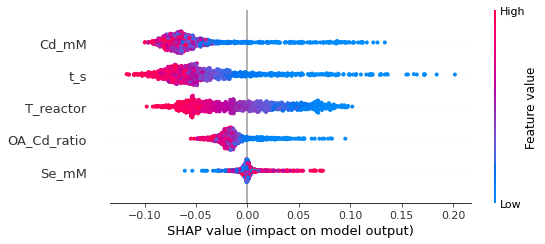

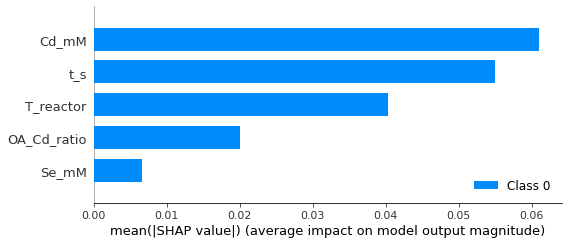

In [13]:
#SHAP on training data for Peak
import shap
explainer = shap.KernelExplainer(model_peak, background)
shap_values1 = explainer.shap_values(test1)
shap.summary_plot(shap_values1[0], test1)
shap.summary_plot(shap_values1, test1, plot_type="bar")
np.savetxt("NN_PL_peak_shap.csv", shap_values1[0], delimiter=",")

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1000 [00:00<?, ?it/s]

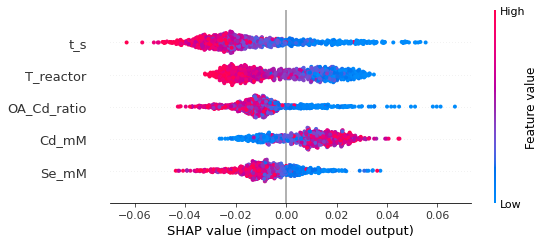

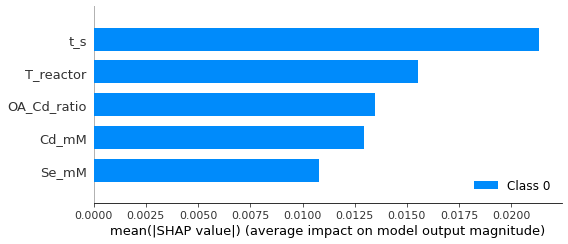

In [14]:
#SHAP on training data for FWHM
explainer = shap.KernelExplainer(model_fwhm, background)
shap_values2 = explainer.shap_values(test1)
shap.summary_plot(shap_values2[0], test1)
shap.summary_plot(shap_values2, test1, plot_type="bar")
np.savetxt("NN_PL_fwhm_shap.csv", shap_values2[0], delimiter=",")

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1000 [00:00<?, ?it/s]

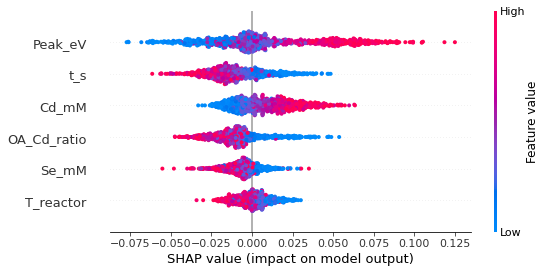

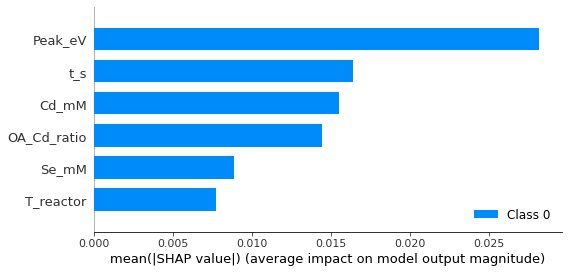

In [15]:
#SHAP on training data for FWHM (cascade)
explainer = shap.KernelExplainer(model_cascade, background2)
shap_values3 = explainer.shap_values(test2)
shap.summary_plot(shap_values3[0], test2)
shap.summary_plot(shap_values3, test2, plot_type="bar")
np.savetxt("NN_PL_cascade_shap.csv", shap_values3[0], delimiter=",")

In [16]:
#Test NN on interpolation without dropout, PL Peak, FWHM (eV)

#Test data set (interpolation)
df2 = pd.read_csv('CdSe PL Test (in).csv')
#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df2[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
y = df2['Peak_eV']
z = df2['FWHM_eV']

X_test = X
y_test = y
z_test = z


#prediction for Peak
y_pred = model_peak.predict(X_test)
#prediction for FWHM (direct)
y_pred_fwhm = model_fwhm.predict(X_test)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", model_peak.predict(X_test), True)
y_pred_cascade = model_cascade.predict(X_test)


matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

j=0

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorption Peak/FWHM Interpolation (no dropout at inference)' + '\033[0m')
print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

y_test = y_test.to_numpy().reshape(1,-1)
z_test = z_test.to_numpy().reshape(1,-1)
y_pred = y_pred.reshape(1,-1)
y_pred_fwhm = y_pred_fwhm.reshape(1,-1)
y_pred_cascade = y_pred_cascade.reshape(1,-1)

np.savetxt("NN_PL_in_test_peak.csv", np.vstack((y_test,y_pred)).T, delimiter=",")
np.savetxt("NN_PL_in_test_fwhm.csv", np.vstack((z_test,y_pred_fwhm)).T, delimiter=",")
np.savetxt("NN_PL_in_test_cascade.csv", np.vstack((z_test,y_pred_cascade)).T, delimiter=",")

15/15 [==============================] - 0s 440us/step
Absorption Peak/FWHM Interpolation (no dropout at inference)
Absorbance Peak
MAE (eV):	 0.0204
R2 (eV):	 0.9654
RAE (eV):	 0.1694
RMSE (eV):	 0.0264
MAE (nm):	 4.6351
R2 (nm):	 0.9665
RAE (nm):	 0.1685
RMSE (nm):	 5.8719
Absorbance FWHM (direct)
MAE (eV):	 0.0093
R2 (eV):	 0.5570
RAE (eV):	 0.5448
RMSE (eV):	 0.0155
MAE (nm):	 2.1831
R2 (nm):	 0.6775
RAE (nm):	 0.4623
RMSE (nm):	 3.4493
Absorbance FWHM (cascade)
MAE (eV):	 0.0062
R2 (eV):	 0.7509
RAE (eV):	 0.3633
RMSE (eV):	 0.0116
MAE (nm):	 1.4754
R2 (nm):	 0.8437
RAE (nm):	 0.3124
RMSE (nm):	 2.4013


In [17]:
#Test NN on interpolation with dropout, PL Peak, FWHM (eV)

#Test data set (interpolation)
df2 = pd.read_csv('CdSe PL Test (in).csv')
#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df2[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
y = df2['Peak_eV']
z = df2['FWHM_eV']

X_test = X
y_test = y
z_test = z

X_test_t = K.constant(X_test)

#prediction for Peak
y_pred =  predict_point(X_test_t, model_peak, 1000)
#prediction for FWHM (direct)
y_pred_fwhm = predict_point(X_test_t, model_fwhm, 1000)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", y_pred, True)
X_test_t = K.constant(X_test)
y_pred_cascade = predict_point(X_test_t, model_cascade, 1000)

matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

j=0

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorption Peak/FWHM Interpolation (with dropout at inference)' + '\033[0m')
print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

y_test = y_test.to_numpy().reshape(1,-1)
z_test = z_test.to_numpy().reshape(1,-1)
y_pred = y_pred.reshape(1,-1)
y_pred_fwhm = y_pred_fwhm.reshape(1,-1)
y_pred_cascade = y_pred_cascade.reshape(1,-1)

np.savetxt("MCNN_PL_in_test_peak.csv", np.vstack((y_test,y_pred)).T, delimiter=",")
np.savetxt("MCNN_PL_in_test_fwhm.csv", np.vstack((z_test,y_pred_fwhm)).T, delimiter=",")
np.savetxt("MCNN_PL_in_test_cascade.csv", np.vstack((z_test,y_pred_cascade)).T, delimiter=",")

Absorption Peak/FWHM Interpolation (with dropout at inference)
Absorbance Peak
MAE (eV):	 0.0193
R2 (eV):	 0.9674
RAE (eV):	 0.1606
RMSE (eV):	 0.0256
MAE (nm):	 4.3475
R2 (nm):	 0.9693
RAE (nm):	 0.1580
RMSE (nm):	 5.6219
Absorbance FWHM (direct)
MAE (eV):	 0.0095
R2 (eV):	 0.5489
RAE (eV):	 0.5543
RMSE (eV):	 0.0156
MAE (nm):	 2.2198
R2 (nm):	 0.6676
RAE (nm):	 0.4700
RMSE (nm):	 3.5018
Absorbance FWHM (cascade)
MAE (eV):	 0.0062
R2 (eV):	 0.7543
RAE (eV):	 0.3648
RMSE (eV):	 0.0115
MAE (nm):	 1.4751
R2 (nm):	 0.8465
RAE (nm):	 0.3124
RMSE (nm):	 2.3797


In [18]:
#Test Linear model on extrapolation, PL Peak, FWHM (eV)

#Test data set (extrapolation)
df2 = pd.read_csv('CdSe PL Test (out).csv')
#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df2[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
y = df2['Peak_eV']
z = df2['FWHM_eV']

X_test = X
y_test = y
z_test = z

#prediction for Peak
y_pred = model_peak.predict(X_test)
#prediction for FWHM (direct)
y_pred_fwhm = model_fwhm.predict(X_test)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", model_peak.predict(X_test), True)
y_pred_cascade = model_cascade.predict(X_test)

matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

j=0

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorption Peak/FWHM Extrapolation (no dropout at inference)' + '\033[0m')
print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

y_test = y_test.to_numpy().reshape(1,-1)
z_test = z_test.to_numpy().reshape(1,-1)
y_pred = y_pred.reshape(1,-1)
y_pred_fwhm = y_pred_fwhm.reshape(1,-1)
y_pred_cascade = y_pred_cascade.reshape(1,-1)

np.savetxt("NN_PL_out_test_peak.csv", np.vstack((y_test,y_pred)).T, delimiter=",")
np.savetxt("NN_PL_out_test_fwhm.csv", np.vstack((z_test,y_pred_fwhm)).T, delimiter=",")
np.savetxt("NN_PL_out_test_cascade.csv", np.vstack((z_test,y_pred_cascade)).T, delimiter=",")

13/13 [==============================] - 0s 2ms/step
Absorption Peak/FWHM Extrapolation (no dropout at inference)
Absorbance Peak
MAE (eV):	 0.0377
R2 (eV):	 0.8852
RAE (eV):	 0.3044
RMSE (eV):	 0.0491
MAE (nm):	 9.0720
R2 (nm):	 0.8684
RAE (nm):	 0.3118
RMSE (nm):	 12.2824
Absorbance FWHM (direct)
MAE (eV):	 0.0131
R2 (eV):	 0.1626
RAE (eV):	 0.7459
RMSE (eV):	 0.0186
MAE (nm):	 2.9196
R2 (nm):	 0.1691
RAE (nm):	 0.7804
RMSE (nm):	 4.0746
Absorbance FWHM (cascade)
MAE (eV):	 0.0128
R2 (eV):	 0.1160
RAE (eV):	 0.7280
RMSE (eV):	 0.0191
MAE (nm):	 2.8959
R2 (nm):	 0.0430
RAE (nm):	 0.7741
RMSE (nm):	 4.3728


In [19]:
#Test NN on interpolation with dropout, PL Peak, FWHM (eV)

#Test data set (interpolation)
df2 = pd.read_csv('CdSe PL Test (out).csv')
#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df2[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
y = df2['Peak_eV']
z = df2['FWHM_eV']

X_test = X
y_test = y
z_test = z

X_test_t = K.constant(X_test)

#prediction for Peak
y_pred =  predict_point(X_test_t, model_peak, 1000)
#prediction for FWHM (direct)
y_pred_fwhm = predict_point(X_test_t, model_fwhm, 1000)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", y_pred, True)
X_test_t = K.constant(X_test)
y_pred_cascade = predict_point(X_test_t, model_cascade, 1000)

matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

j=0

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorption Peak/FWHM Extrapolation (with dropout at inference)' + '\033[0m')
print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

y_test = y_test.to_numpy().reshape(1,-1)
z_test = z_test.to_numpy().reshape(1,-1)
y_pred = y_pred.reshape(1,-1)
y_pred_fwhm = y_pred_fwhm.reshape(1,-1)
y_pred_cascade = y_pred_cascade.reshape(1,-1)

np.savetxt("MCNN_PL_out_test_peak.csv", np.vstack((y_test,y_pred)).T, delimiter=",")
np.savetxt("MCNN_PL_out_test_fwhm.csv", np.vstack((z_test,y_pred_fwhm)).T, delimiter=",")
np.savetxt("MCNN_PL_out_test_cascade.csv", np.vstack((z_test,y_pred_cascade)).T, delimiter=",")

Absorption Peak/FWHM Extrapolation (with dropout at inference)
Absorbance Peak
MAE (eV):	 0.0359
R2 (eV):	 0.8966
RAE (eV):	 0.2896
RMSE (eV):	 0.0466
MAE (nm):	 8.6116
R2 (nm):	 0.8827
RAE (nm):	 0.2960
RMSE (nm):	 11.5968
Absorbance FWHM (direct)
MAE (eV):	 0.0129
R2 (eV):	 0.1894
RAE (eV):	 0.7344
RMSE (eV):	 0.0183
MAE (nm):	 2.9006
R2 (nm):	 0.2110
RAE (nm):	 0.7754
RMSE (nm):	 3.9704
Absorbance FWHM (cascade)
MAE (eV):	 0.0130
R2 (eV):	 0.0729
RAE (eV):	 0.7417
RMSE (eV):	 0.0196
MAE (nm):	 2.8830
R2 (nm):	 0.0006
RAE (nm):	 0.7707
RMSE (nm):	 4.4687
